Testing code on DIGITS dataset

In [1]:
import sys
sys.path.append('D:\\Desktop\\Lipschitz_DSNN') 

In [2]:
import numpy as np
import torch
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
# from torch.utils import tensorboard
import torch.nn as nn


from architectures.base_model import BaseModel
from architectures.simple_fc import SimpleFC
from layers.lipschitzlinear import LipschitzLinear
from projections.fc_projections import identity, bjorck_orthonormalize_fc, layerwise_orthogonal_fc
from utils import metrics, utilities, spline_utils
from dataloader.Function_1D import Function1D, generate_testing_set, slope_1_ae, slope_1_flat, cosines, threshold
from activations.linearspline import LinearSpline

In [3]:
### let's load the SimpleFCClassification model
from classification_LS import SimpleFCClassification # it works

In [4]:
## importing the trainer 
from trainer_class_LS_test import CustomDataset, Trainer_classification

In [5]:
### importing some utility functions
from utils_test_classification import plot_confusion_matrix, plot_losses_trained_model

In [6]:
### function to evaluate the trained model
def evaluate_model(trained_model_input, y_test_fn, dataset_size=100, noise_level=0.003, 
                    want_confusion_matrix=False,
                    print_preds=False, range_of_value=1):
    # Generate test dataset
    x_test = np.random.uniform(-range_of_value, range_of_value, size=(dataset_size, 2)) + noise_level * np.ones(shape=(dataset_size, 2))
    y_test = y_test_fn(x_test)
    #print(f"y_test is:"); print(y_test)

    # Convert to torch tensors
    x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)

    # Make predictions
    with torch.no_grad():
        preds = trained_model_input(x_test)
        if print_preds:
            print("predictions are:")
            print(preds)

    # Calculate accuracy
    acc_test = (preds.squeeze().round() == y_test).float().mean()
    print(f"Test accuracy: {acc_test.item():.4f}")
    # Plot confusion matrix
    if want_confusion_matrix:
        plot_confusion_matrix(preds.squeeze().round(), y_test, classes=["0", "1"])
    
    return x_test, y_test, preds

Loading the DIGITS dataset

In [7]:
from sklearn.datasets import load_digits
from sklearn import model_selection

# setup
digits = load_digits()
images = digits["images"]
flat_images_unnorm= images.reshape((images.shape[0],-1))
print(f"shape of flattened images: {flat_images_unnorm.shape}")
target = digits["target"] 
target_names = digits["target_names"] 

# normalising the dataset
flat_images_norm = (1./np.max(flat_images_unnorm))*flat_images_unnorm

### even digits as label 0 and odd digits as label 1
tgt = np.where(target%2==0, 0, 1) 

shape of flattened images: (1797, 64)


In [8]:
# defining config dict for LOT and bjorck orthonormalisation
import copy
### model parameters
network_param = {'bias': True,
    'layer_sizes': [64, 8, 1], ### we will consider 2-D Example later on
    'projection': 'no_projection' , ### Let's change it from 'orthonormalize' to 'no_projection'
    'weight_initialization': 'orthonormal'}

additional_network_params= {'activation_type': 'linearspline', ### this is of interest
    'groupsort_groupsize': 5,
    'prelu_init': -1,
    'lipschitz_constrained': True,### this is of interest
    'spline_init': 'relu',### this is of interest
    'spline_range': 0.9,### this is of interest [-1,1]
    'spline_scaling_coeff': True,### this is of interest
    'spline_size': 19,#101,###
    'lmbda': 1e-07}### this is of interest [e-10,e2]

for_optimizer = {'lr_spline_coeffs': 5e-05, # idk what exactly is this. Need to look into it well
    'lr_spline_scaling_coeffs': 0.0005,
    'lr_weights': 0.002}# original 0.002, i changed it to 0.01

training_options = {'batch_size': 32,  
    'epochs': 20,
    'nbr_models': 1,
    'num_workers': 1,
    'validation_split':0.1}

config_train_classification_digits = { 'activation_fn_params':additional_network_params,
                            'exp_name' : "digits 3 and 7 classification",
                            'net_params' : network_param,
                            'optimizer' : for_optimizer,
                            'training_options' : training_options
}
# for LOT
config_train_classification_LOT_digits = copy.deepcopy(config_train_classification_digits)
config_train_classification_LOT_digits['net_params']['projection'] = 'orthonormalize'
config_train_classification_LOT_digits['net_params']['LOT'] = {'LOT_iter': 10}
config_train_classification_LOT_digits['training_options']['epochs']=20


# FOR Bjorck orthonormalisation
config_train_classification_bjorck= copy.deepcopy(config_train_classification_digits)
config_train_classification_bjorck['net_params']['projection']='orthonormalize'

### First let's test both bjorck and LOT orthonormalisation based models with normalised data $\mathcal{O}(1)$

1. Bjorck, normalised data

In [9]:
## criterion is: criterion
# print("BJORCK, NORMALISED DATA")
# criterion= nn.BCELoss()

# ## model
# ## defining the model
# model_bjorck_digits_norm= SimpleFCClassification(network_parameters=config_train_classification_bjorck['net_params'],
#                              **additional_network_params)
# model_bjorck_digits_norm =model_bjorck_digits_norm.to('cpu')
# print("model is:"); print(model_bjorck_digits_norm)

# ### instantiate the Trainer 
# trainer_classification_bjorck_digits_norm = Trainer_classification(model=model_bjorck_digits_norm,
#                                                 xdata=flat_images_norm,
#                                                 ydata= tgt,
#                                                 criterion=criterion,
#                                                 config= config_train_classification_bjorck,
#                                                 seed=12,
#                                                 device='cpu',
#                                                 print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
#                                                 )

# ### Let's train the model
# trainer_classification_bjorck_digits_norm.train() ### 

# ### plotting loss curves
# plot_losses_trained_model(trainer_classification_bjorck_digits_norm)

2. LOT, normalised data

In [10]:
# ## criterion is: criterion
# print("LOT WITH NORMALISED DIGITS DATA")
# criterion= nn.BCELoss()

# ## model
# ## defining the model
# model_LOT_digits_norm= SimpleFCClassification(network_parameters=config_train_classification_LOT_digits['net_params'],
#                              **additional_network_params)
# model_LOT_digits_norm =model_LOT_digits_norm.to('cpu')
# print("model is:"); print(model_LOT_digits_norm)

# ### instantiate the Trainer 
# trainer_classification_LOT_digits_norm = Trainer_classification(model=model_LOT_digits_norm,
#                                                 xdata=flat_images_norm,
#                                                 ydata= tgt,
#                                                 criterion=criterion,
#                                                 config= config_train_classification_LOT_digits,
#                                                 seed=12,
#                                                 device='cpu',
#                                                 print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
#                                                 )

# ### Let's train the model
# trainer_classification_LOT_digits_norm.train() ### 

# ### plotting loss curves
# plot_losses_trained_model(trainer_classification_LOT_digits_norm)

3. Without othonormalisation of linear layers, with normalised data

In [11]:
# # Define the criterion
# criterion = nn.BCELoss()

# # Define the model
# simple_fc_model_digits_norm= SimpleFCClassification(network_parameters=config_train_classification_digits['net_params'], 
#                                           **additional_network_params)
# simple_fc_model_digits_norm = simple_fc_model_digits_norm.to('cpu')
# print("Model is:")
# print(simple_fc_model_digits_norm)

# # Instantiate the Trainer
# trainer_no_ortho_norm= Trainer_classification(model=simple_fc_model_digits_norm,
#                                     xdata=flat_images_norm,
#                                     ydata=tgt,
#                                     criterion=criterion,
#                                     config=config_train_classification_digits,
#                                     seed=12,
#                                     device='cpu',
#                                     print_after_epoch=1000
#                                     )

# # Train the model
# trainer_no_ortho_norm.train()

# ### plotting loss curves
# plot_losses_trained_model(trainer_no_ortho_norm)

### Now Let's try with scaled dataset (unnormalised dataset), $\mathcal{O}(10)$ 

1. Bjorck

In [12]:
print("BJORCK WITH UNNORM DATA")
## criterion is: criterion
criterion= nn.BCELoss()
scale_factor_list=[0.05,1,5,10,100]
trainer_model_dict = {}
## model
## defining the model

for scale_factor in scale_factor_list:
    print(f"---scale factor: {scale_factor} ---")
    model_bjorck_digits_unnorm= SimpleFCClassification(network_parameters=config_train_classification_bjorck['net_params'],
                                **additional_network_params)
    model_bjorck_digits_unnorm =model_bjorck_digits_unnorm.to('cpu')
    print("model is:"); print(model_bjorck_digits_unnorm)

    ### instantiate the Trainer 
    trainer_classification_bjorck_digits_unnorm = Trainer_classification(model=model_bjorck_digits_unnorm,
                                                    xdata=scale_factor* flat_images_norm,
                                                    ydata= tgt,
                                                    criterion=criterion,
                                                    config= config_train_classification_bjorck,
                                                    seed=12,
                                                    device='cpu',
                                                    print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                    )

    ### Let's train the model
    trainer_classification_bjorck_digits_unnorm.train() ### 
    trainer_model_dict[scale_factor] = trainer_classification_bjorck_digits_unnorm

# ### plotting loss curves
# for scale_factor in scale_factor_list:
#     print(f"---scale factor: {scale_factor}")
#     plot_losses_trained_model(trainer_model_dict[scale_factor])
    #plot_losses_trained_model(trainer_classification_bjorck_digits_unnorm)

BJORCK WITH UNNORM DATA
---scale factor: 0.05 ---
Orthonormalisation will take place.
Bjorck and Bowie orthonormalisation will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


 10%|▉         | 5/51 [00:00<00:01, 38.58it/s]

---scale factor: 1 ---
Orthonormalisation will take place.
Bjorck and Bowie orthonormalisation will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


  8%|▊         | 4/51 [00:00<00:01, 38.98it/s]

---scale factor: 5 ---
Orthonormalisation will take place.
Bjorck and Bowie orthonormalisation will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


  8%|▊         | 4/51 [00:00<00:01, 38.83it/s]

---scale factor: 10 ---
Orthonormalisation will take place.
Bjorck and Bowie orthonormalisation will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


  6%|▌         | 3/51 [00:00<00:01, 29.40it/s]

---scale factor: 100 ---
Orthonormalisation will take place.
Bjorck and Bowie orthonormalisation will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


100%|██████████| 51/51 [00:01<00:00, 30.46it/s]


---scale factor: 0.05


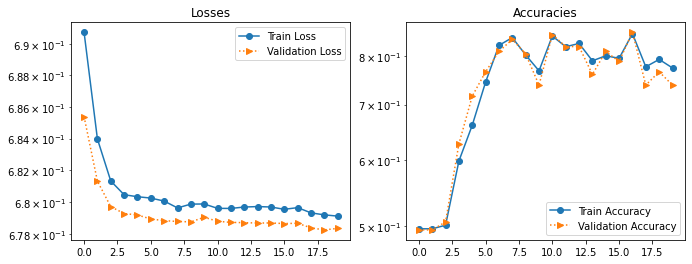

Final training accuracy is: 0.775
Final validation accuracy is: 0.739
---scale factor: 1


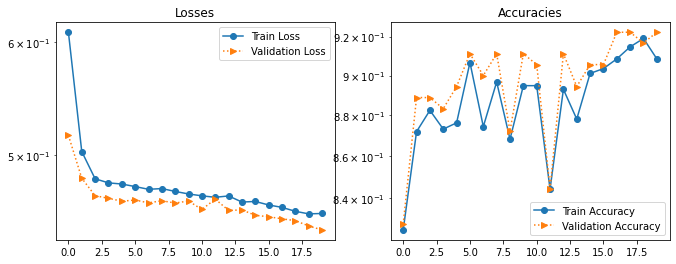

Final training accuracy is: 0.908
Final validation accuracy is: 0.922
---scale factor: 5


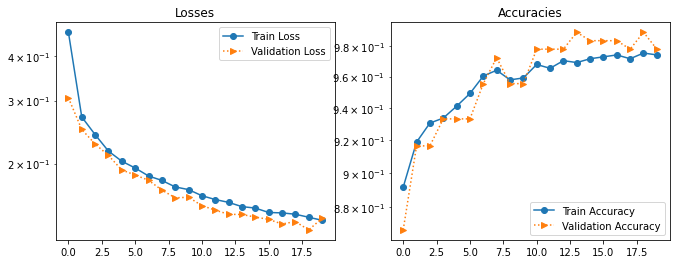

Final training accuracy is: 0.974
Final validation accuracy is: 0.978
---scale factor: 10


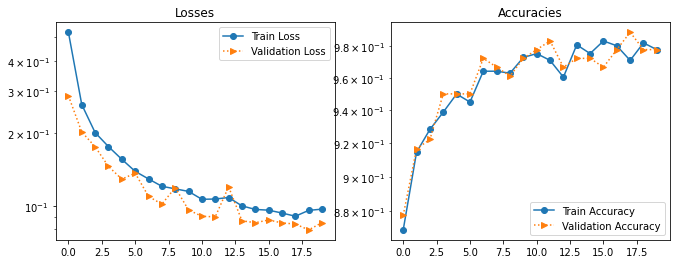

Final training accuracy is: 0.978
Final validation accuracy is: 0.978
---scale factor: 100


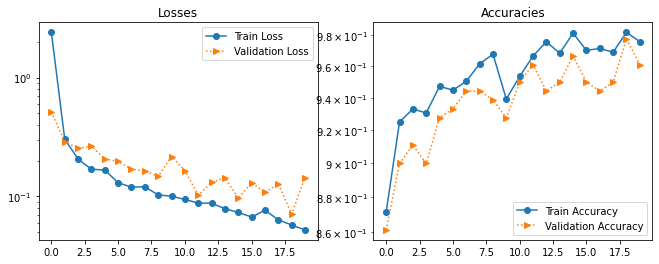

Final training accuracy is: 0.976
Final validation accuracy is: 0.961


In [13]:
### plotting loss curves
for scale_factor in scale_factor_list:
    print(f"---scale factor: {scale_factor}")
    plot_losses_trained_model(trainer_model_dict[scale_factor], want_logscale=True)

2. LOT

In [16]:
# ## criterion is: criterion
print("LOT WITH UNNORMALISED DIGITS DATA")
criterion= nn.BCELoss()

## model
## defining the model
trainer_LOT_unnorm_scaling_dict={}
for scale_factor in scale_factor_list:
    model_LOT_digits_unnorm= SimpleFCClassification(network_parameters=config_train_classification_LOT_digits['net_params'],
                                **additional_network_params)
    model_LOT_digits_unnorm =model_LOT_digits_unnorm.to('cpu')
    print("model is:"); print(model_LOT_digits_unnorm)

    ### instantiate the Trainer 
    trainer_classification_LOT_digits_unnorm = Trainer_classification(model=model_LOT_digits_unnorm,
                                                    xdata=scale_factor*flat_images_norm,
                                                    ydata= tgt,
                                                    criterion=criterion,
                                                    config= config_train_classification_LOT_digits,
                                                    seed=12,
                                                    device='cpu',
                                                    print_after_epoch=1000 # I dont want to print coz I am plotting them in the end anyways
                                                    )

    ### Let's train the model
    trainer_classification_LOT_digits_unnorm.train() ### 
    trainer_LOT_unnorm_scaling_dict[scale_factor] = trainer_classification_LOT_digits_unnorm

# ### plotting loss curves
# plot_losses_trained_model(trainer_classification_LOT_digits_unnorm)

  0%|          | 0/51 [00:00<?, ?it/s]

LOT WITH UNNORMALISED DIGITS DATA
Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


  8%|▊         | 4/51 [00:00<00:01, 37.11it/s]

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


  8%|▊         | 4/51 [00:00<00:01, 34.60it/s]

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


  0%|          | 0/51 [00:00<?, ?it/s]

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


  8%|▊         | 4/51 [00:00<00:01, 39.82it/s]

Orthonormalisation will take place.
LOT orthonormalization will take place
model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


100%|██████████| 51/51 [00:01<00:00, 40.25it/s]


---scale factor: 0.05


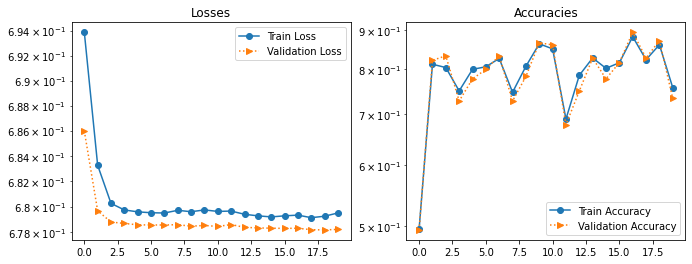

Final training accuracy is: 0.758
Final validation accuracy is: 0.733
---scale factor: 1


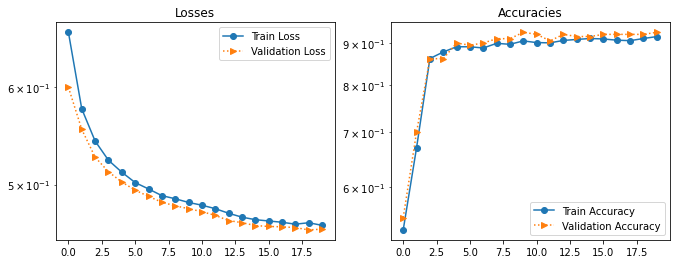

Final training accuracy is: 0.917
Final validation accuracy is: 0.928
---scale factor: 5


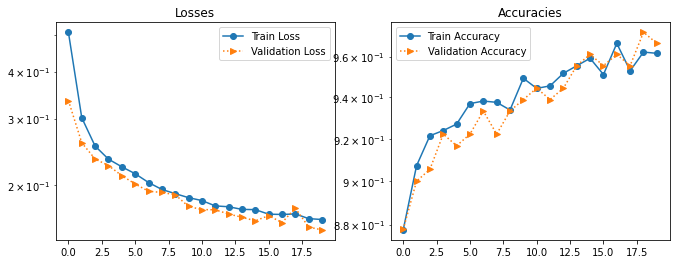

Final training accuracy is: 0.962
Final validation accuracy is: 0.967
---scale factor: 10


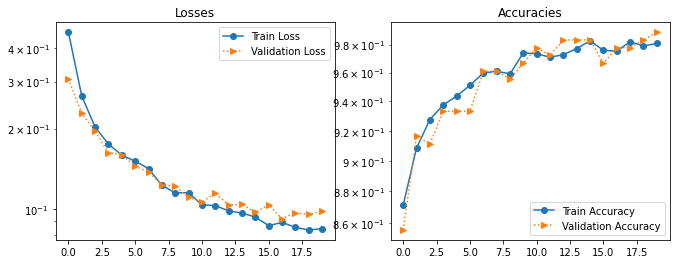

Final training accuracy is: 0.981
Final validation accuracy is: 0.989
---scale factor: 100


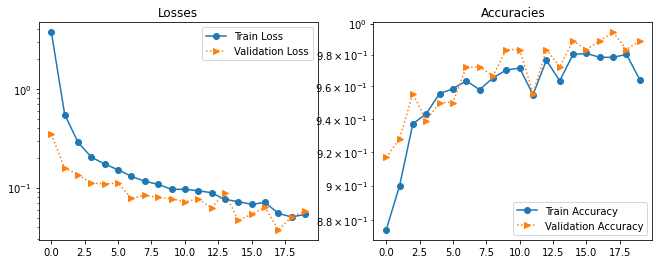

Final training accuracy is: 0.964
Final validation accuracy is: 0.989


In [17]:
### plotting loss curves
for scale_factor in scale_factor_list:
    print(f"---scale factor: {scale_factor}")
    plot_losses_trained_model(trainer_LOT_unnorm_scaling_dict[scale_factor], want_logscale=True)

3. No orthonormalisation of linear layers, with unnorm data

In [18]:
# Define the criterion
criterion = nn.BCELoss()


trainer_no_orth_dict={}
# Define the model
for scale_factor in scale_factor_list:
    simple_fc_model_digits_unnorm= SimpleFCClassification(
        network_parameters=config_train_classification_digits['net_params'], 
        **additional_network_params)
    simple_fc_model_digits_unnorm = simple_fc_model_digits_unnorm.to('cpu')
    print("Model is:")
    print(simple_fc_model_digits_unnorm)

    # Instantiate the Trainer
    trainer_no_ortho_unnorm= Trainer_classification(model=simple_fc_model_digits_unnorm,
                                        xdata=scale_factor*flat_images_norm,
                                        ydata=tgt,
                                        criterion=criterion,
                                        config=config_train_classification_digits,
                                        seed=12,
                                        device='cpu',
                                        print_after_epoch=1000
                                        )

    # Train the model
    trainer_no_ortho_unnorm.train()
    trainer_no_orth_dict[scale_factor]=trainer_no_ortho_unnorm

# ### plotting loss curves
# plot_losses_trained_model(trainer_no_ortho_unnorm)

  2%|▏         | 1/51 [00:00<00:06,  7.63it/s]

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


 18%|█▊        | 9/51 [00:00<00:00, 84.12it/s]

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


 20%|█▉        | 10/51 [00:00<00:00, 91.42it/s]

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


 18%|█▊        | 9/51 [00:00<00:00, 83.70it/s]

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


 20%|█▉        | 10/51 [00:00<00:00, 86.46it/s]

no orthonormalisation. projection= identity
Model is:
SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=64, out_features=8, bias=True)
    (1): LinearSpline(mode=fc, num_activations=8, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
in Train set: # class 0 DPs: 802 and # class 1 DPs: 815
in val set: # class 0 DPs: 89 and # class 1 DPs: 91


100%|██████████| 51/51 [00:00<00:00, 86.46it/s]


---scale factor: 0.05


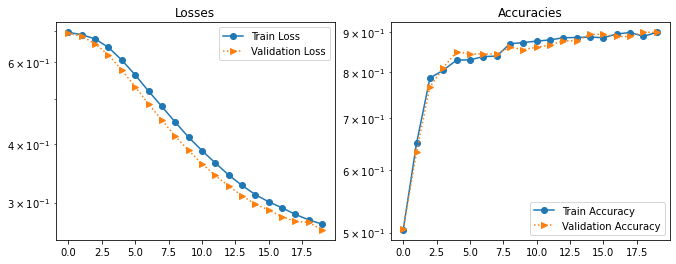

Final training accuracy is: 0.900
Final validation accuracy is: 0.900
---scale factor: 1


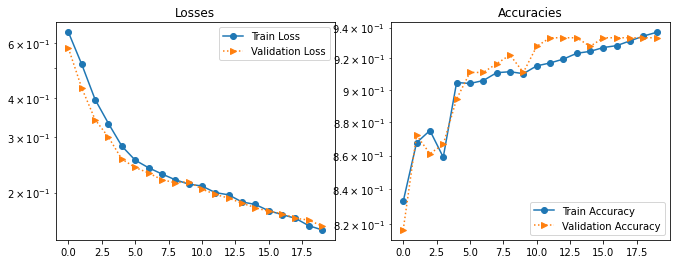

Final training accuracy is: 0.937
Final validation accuracy is: 0.933
---scale factor: 5


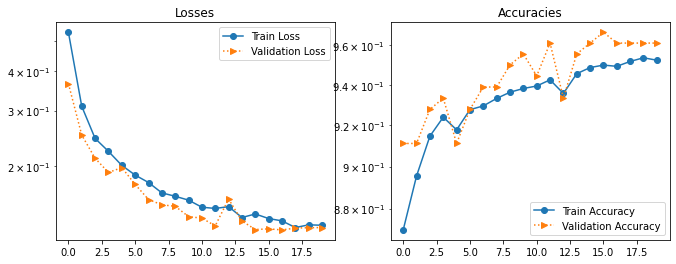

Final training accuracy is: 0.952
Final validation accuracy is: 0.961
---scale factor: 10


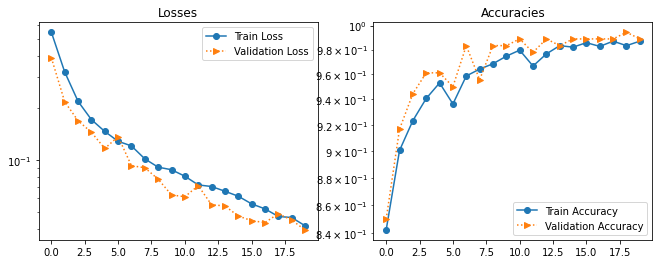

Final training accuracy is: 0.987
Final validation accuracy is: 0.989
---scale factor: 100


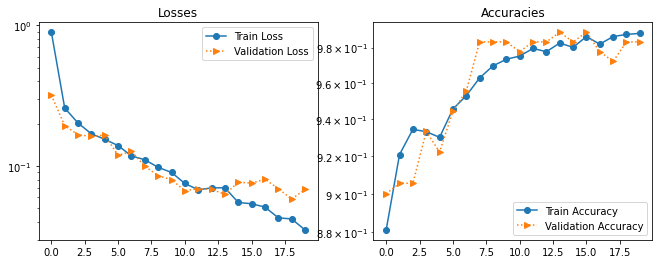

Final training accuracy is: 0.988
Final validation accuracy is: 0.983


In [19]:
### plotting loss curves
for scale_factor in scale_factor_list:
    print(f"---scale factor: {scale_factor}")
    plot_losses_trained_model(trainer_no_orth_dict[scale_factor], want_logscale=True)